Florestas Causais

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
from lightgbm import LGBMRegressor


In [ ]:

path_to_the_truth = r"../dados/microdados_enem_2019/dados_enem_processados_v2.csv.zip"

df = pd.read_csv(path_to_the_truth, sep=",", encoding="utf-8", compression="zip")




: 

In [ ]:
n_samples= min(500000, len(df))

sample=df.sample(n_samples, random_state=666).copy()

: 

In [ ]:
sample.set_index('NU_INSCRICAO', inplace=True)

: 

In [ ]:
scaler = StandardScaler()
sample[['NOTA_ENEM_STD', 'SCORE_CULTURAL_STD']] = scaler.fit_transform(
    sample[['MEDIA_CANDIDATO', 'SCORE_CULT_PAIS']] 
)


: 

In [ ]:
categorical_cols = ['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'INTERNET']
df_encoded = pd.get_dummies(sample, columns=categorical_cols, drop_first=True)


: 

In [ ]:
Y = df_encoded['NOTA_ENEM_STD']     
T = df_encoded['SCORE_CULTURAL_STD'] 

# Confundidores (W) e variáveis de heterogeneidade (X)

X = df_encoded.drop(columns=['MEDIA_CANDIDATO', 'NOTA_ENEM_STD', 'SCORE_CULT_PAIS', 'SCORE_CULTURAL_STD'])
W = X.copy() # 


: 

In [ ]:
# vamo usar um modelo não tão grande para não overfittar
model_y = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)
model_t = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.05)

est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    criterion='het',        #RESULTADOS EXPERIMENTAIS: 
    n_estimators=1000,       # Mais árvores = mais estabilidade no desvio 
    min_samples_leaf=500,    # Aumentar esse valor é o que mais reduz o desvio alto
    max_depth=5,             # Limita a complexidade da floresta
    discrete_treatment=False, #  tratamento agora é contínuo (vulgo Z-score)
    inference=True,
    random_state=666
)

#
est.fit(Y, T, X=X, W=W, cache_values=True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 38
[LightGBM] [Info] Start training from score 0.001243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

: 

In [ ]:
#sumário
ate_inf = est.ate_inference(X)
print(ate_inf.summary())

               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     0.117        0.01 11.811    0.0         0.097         0.136
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.036           0.068           0.217
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.038          0.064          0.216
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


: 

O sumário acima indica que o **efeito causal médio** do capital cultural (anos de formação dos pais) é **estatisticamente significante**, com  
$p \approx 0$, para a hipótese nula $H_0: \text{ATE} = 0$.

A estimativa média do efeito é de $\widehat{\text{ATE}} = 0{,}117$ desvios-padrão da variável **nota**, para cada desvio-padrão adicional de capital cultural.

Como o desvio-padrão das notas dos candidatos em 2019 foi de aproximadamente $\sigma_{\text{nota}} \approx 80$ pontos (ver análise exploratória), um aumento de **1 desvio-padrão** no capital cultural está associado, em média, a um ganho de cerca de $0{,}117 \times 80 \approx 9$ pontos no ENEM.

Contudo, veremos que esse efeito **não é homogêneo** e varia de acordo com o agrupamento (ou subpopulação) considerada.


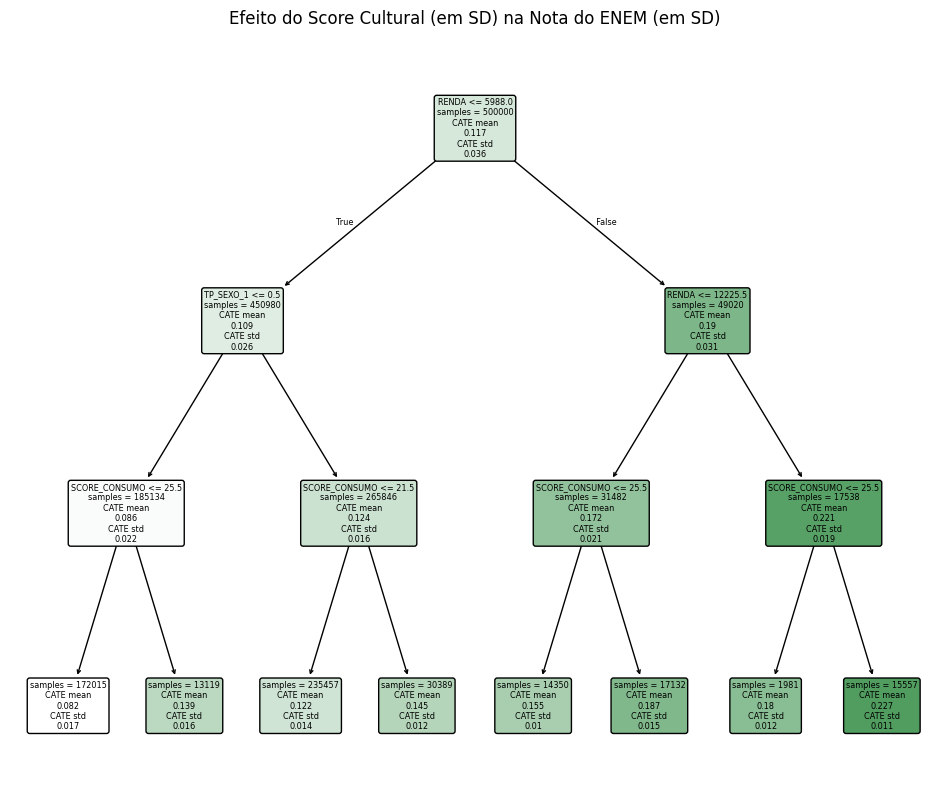

: 

In [ ]:

intrp = SingleTreeCateInterpreter(max_depth=3)
intrp.interpret(est, X)



plt.figure(figsize=(12, 10))
intrp.plot(feature_names=X.columns)
plt.title("Efeito do Score Cultural (em SD) na Nota do ENEM (em SD)")
plt.show()


## Análise

O algoritmo escolheu, como critério de separação para uma árvore de profundidade 3, as variáveis **renda**, **sexo** e *score* de consumo (medida de score da família para eletrodomésticos e serviços como ter empregados).

Nas folhas à esquerda da árvore observamos o **menor efeito da variável de interesse**. Esse efeito ocorre para indivíduos com **renda ≤ R\$ 5.998**, **do sexo feminino** (`TP_SEXO ≤ 0.5`) e com *score* de consumo **< 25.5**. Para esse grupo, o efeito estimado é de aproximadamente **6.5 pontos**, o que é relativamente baixo.

Por outro lado, para indivíduos com **alta renda** (≥ R\$ 12.225,5) e **alto *score* de consumo** (≥ 25.5), o efeito estimado é da ordem de **18 pontos por desvio-padrão da variável de interesse**, o que representa um ganho superior a **200%** quando comparado ao grupo de menor renda e consumo.

Isso evidencia uma **heterogeneidade relevante dos efeitos**, fortemente associada a características socioeconômicas.

Uma limitação evidente do modelo é a presença de **variáveis latentes**, que possivelmente e, não só isso como muito provavelmente, não são capturadas pelos questionários do ENEM (por exemplo, fatores culturais, motivacionais ou ambientais). Reconhecemos, portanto, essa limitação estrutural. Ainda assim, **condicionalmente às variáveis observadas**, os efeitos estimados apresentam **significância estatística**, vide nossa discussão anterior.

Encerramos a análise com outro reconhecimento: o de que apesar de não ser um efeito muito grande, dada a dimensão em que varia a nota da prova, em cursos muito disputados esse efeito é a diferença entre candidato poder entrar nesse curso ou ficar numa posição consideravelmente abaixo na lista de espera.


In [ ]:
ate = est.ate(X)
ate_interval = est.ate_interval(X)

scale = scaler.scale_[0]

ate_transformado = ate * scale

lower = ate_interval[0] * scale
upper = ate_interval[1] * scale

print(
    f"ATE estimado: {ate_transformado:.4f} "
)

print("-"*50)

print(
    f"Intervalo de confiança para o ATE: [{lower:.4f}, {upper:.4f}] "
)

ATE estimado: 9.4322 
--------------------------------------------------
Intervalo de confiança para o ATE: [7.8670, 10.9975] 


: 